In [1]:
from qiskit import IBMQ

# Load Account and Choose Backend
# IBMQ.load_account()
# provider = IBMQ.get_provider('ibm-q')
# name = 'ibmqx2'
# backend = provider.get_backend(name) # ibmq_16_melbourne, ibmq_vigo, ibmq_london, ibmq_burlington, ibmq_essex, ibmqx2, ibmq_ourense

In [2]:
import warnings
import sys
sys.path.insert(1, '../Scripts')
from expfuncs import *
warnings.filterwarnings('ignore')

interested_qubits = [2,1]
itr = 32
QDT_correlated = True
noise_file_address = 'Noise/'
file_address = 'T1/'
#all_methods_data(interested_qubits,backend, itr, QDT_correlated, file_address = noise_file_address)

In [3]:
#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

#Generate RB circuits (2Q RB)
#number of qubits
nQ=2
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1,2,3,4]
#Number of seeds (random sequences)
rb_opts['nseeds'] = 16
#Default pattern
rb_opts['rb_pattern'] = [[1,2]]

# with open(file_address + 'RBparams.csv', newline='',mode='w') as sgr:
#     count_writer = csv.writer(sgr, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#     count_writer.writerow(['nseeds', rb_opts['nseeds']])
#     arr = np.array(['length_vector'])
#     count_writer.writerow(np.append(arr, rb_opts['length_vector']))

# rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)
# print(len(rb_circs))
# rb_circs[0][0].draw(output='mpl')

In [4]:
# circs = []
# name_prefix = []
# name_suffix = []
# for i in range(rb_opts['nseeds']):
#     n2 = 'seed'+str(i)
#     name_suffix.append(n2)
# for j in range(len(rb_opts['length_vector'])):
#     n1 = 'len'+str(rb_opts['length_vector'][j])
#     name_prefix.append(n1)
    
# for n1 in name_prefix:
#     for n2 in name_suffix:
#         circs.append(rb_circs[i][j].copy(n1+n2))

In [5]:
# from qiskit import Aer,QuantumCircuit,transpile,execute,QuantumRegister
# from qiskit.tools.monitor import job_monitor

# backend = Aer.get_backend("qasm_simulator")
# shots = 8192
# job = execute(circs, backend, shots=shots)
# job_monitor(job)
# res = job.result()
# for length in name_prefix:
#     print(length)
#     for seed in name_suffix:
#         print(seed)
#         circ_name = length+seed
#         with open(file_address + circ_name + '.csv',newline='', mode='w') as sgr:
#             count_writer = csv.writer(sgr, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#             for key, val in res.get_counts(circ_name).items():
#                 count_writer.writerow([key,val])

In [6]:
# Create Filters
# Run R file first!
our_filter, qiskit_filter, QDT_filter, SB_filter = create_filters(interested_qubits,QDT_correlated, show_denoised = False, from_file = True, file_address = noise_file_address)

Standard Bayesian filter
Our Filter
Qiskit filter
QDT filter


In [7]:
# Read RB paramsters
with open(file_address + 'RBparams.csv', mode='r') as sgm:
    reader = csv.reader(sgm)
    rb_params = {}
    for row in reader:
        if row[0] == 'nseeds':
            rb_params[row[0]] = int(row[1])
        if row[0] == 'length_vector':
            rb_params[row[0]] = []
            for i in range(1,len(row)):
                rb_params[row[0]].append(int(row[i]))
rb_params

{'nseeds': 16, 'length_vector': [1, 2, 3, 4]}

In [25]:
#Read RB data
import pandas as pd
df = pd.DataFrame({'Length':[], 'Seed':[], 'Probability':[], 'Method':[]})
for length in rb_params['length_vector']:
    for seed in range(rb_params['nseeds']):
        circ_name = 'len{}seed{}'.format(length,seed)
        with open(file_address + circ_name + '.csv', mode='r') as sgm:
            reader = csv.reader(sgm)
            real_counts = {}
            for row in reader:
                if (len(row)> 0):
                    real_counts[row[0]] = int(row[1])
        #print(real_counts)
        mean_counts = our_filter.filter_mean(real_counts)
        mode_counts = our_filter.filter_mode(real_counts)
        qis_counts = qiskit_filter.apply(real_counts)
        QDT_counts = QDT_filter.filter(real_counts)
        sbmean_counts = SB_filter.filter_mean(real_counts)
        sbmode_counts = SB_filter.filter_mode(real_counts)
        df = df.append({'Length': length, 'Seed': seed, 'Probability': real_counts['00']/8192, 'Method': 'Raw'}, ignore_index=True)
#         df = df.append({'Length': length, 'Seed': seed, 'Probability': mean_counts['00']/8192, 'Method': 'Cons. Mean'}, ignore_index=True)
#         df = df.append({'Length': length, 'Seed': seed, 'Probability': mode_counts['00']/8192, 'Method': 'Con. MAP'}, ignore_index=True)
        df = df.append({'Length': length, 'Seed': seed, 'Probability': sbmean_counts['00']/8192, 'Method': 'Stand. Mean'}, ignore_index=True)
#         df = df.append({'Length': length, 'Seed': seed, 'Probability': sbmode_counts['00']/8192, 'Method': 'Stand. MAP'}, ignore_index=True)
        df = df.append({'Length': length, 'Seed': seed, 'Probability': qis_counts['00']/8192, 'Method': 'Qiskit'}, ignore_index=True)
        df = df.append({'Length': length, 'Seed': seed, 'Probability': QDT_counts['00']/8192, 'Method': 'QDT'}, ignore_index=True)
#df

In [26]:
import seaborn as sns

_widths = {
    # a4paper columnwidth = 426.79135 pt = 5.93 in
    # letterpaper columnwidth = 443.57848 pt = 6.16 in
    'onecolumn': {
        'a4paper' : 5.93,
        'letterpaper' : 6.16
    },
    # a4paper columnwidth = 231.84843 pt = 3.22 in
    # letterpaper columnwidth = 240.24199 pt = 3.34 in
    'twocolumn': {
        'a4paper' : 3.22,
        'letterpaper' : 3.34
    }
}

_wide_widths = {
    # a4paper wide columnwidth = 426.79135 pt = 5.93 in
    # letterpaper wide columnwidth = 443.57848 pt = 6.16 in
    'onecolumn': {
        'a4paper' : 5.93,
        'letterpaper' : 6.16
    },
    # a4paper wide linewidth = 483.69687 pt = 6.72 in
    # letterpaper wide linewidth = 500.48400 pt = 6.95 in
    'twocolumn': {
        'a4paper' : 6.72,
        'letterpaper' : 6.95
    }
}

_fontsizes = {
    10 : {
        'tiny' : 5,
        'scriptsize' : 7,
        'footnotesize' : 8, 
        'small' : 9, 
        'normalsize' : 10,
        'large' : 12, 
        'Large' : 14, 
        'LARGE' : 17,
        'huge' : 20,
        'Huge' : 25
    },
    11 : {
        'tiny' : 6,
        'scriptsize' : 8,
        'footnotesize' : 9, 
        'small' : 10, 
        'normalsize' : 11,
        'large' : 12, 
        'Large' : 14, 
        'LARGE' : 17,
        'huge' :  20,
        'Huge' :  25
    },
    12 : {
        'tiny' : 6,
        'scriptsize' : 8,
        'footnotesize' : 10, 
        'small' : 11, 
        'normalsize' : 12,
        'large' : 14, 
        'Large' : 17, 
        'LARGE' : 20,
        'huge' :  25,
        'Huge' :  25
    }
}

_width         = 1
_wide_width    = 1
_quantumviolet = '#53257F'
_quantumgray   = '#555555'


columns = 'twocolumn'
paper = 'a4paper'
fontsize = 10


plt.rcdefaults()
    
# Seaborn white is a good base style
plt.style.use(['seaborn-white', '../Plots/quantum-plots.mplstyle'])


_width = _widths[columns][paper]

 
_wide_width = _wide_widths[columns][paper]

# Use the default fontsize scaling of LaTeX

fontsizes = _fontsizes[fontsize]

plt.rcParams['axes.labelsize'] = fontsizes['small']
plt.rcParams['axes.titlesize'] = fontsizes['large']
plt.rcParams['xtick.labelsize'] = fontsizes['footnotesize']
plt.rcParams['ytick.labelsize'] = fontsizes['footnotesize']
plt.rcParams['font.size'] = fontsizes['small']

aspect_ratio = 1/1.62
width_ratio = 1.0
wide = False

width = (_wide_width if wide else _width) * width_ratio
height = width * aspect_ratio

plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (width,height)

Length 1


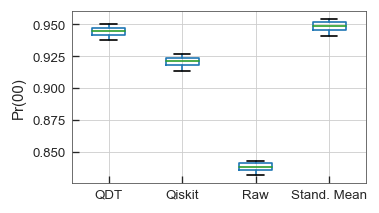

Length 2


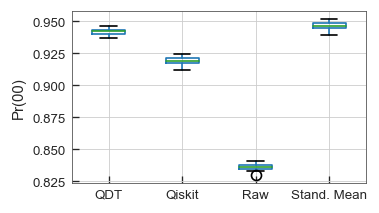

Length 3


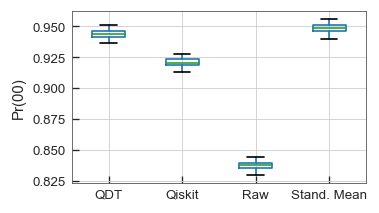

Length 4


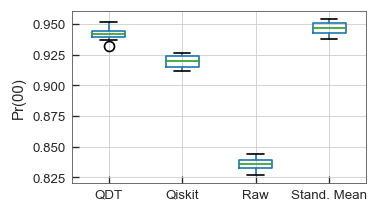

In [28]:
for length in rb_params['length_vector']:
    print('Length {}'.format(length))
    sub_df = df.loc[df['Length'] == length].drop(['Seed'], axis = 1)
    ax = sub_df.boxplot(column = 'Probability', by = 'Method')
#     ax.set_xlabel('',  fontsize=14)
#     ax.set_ylabel('Pr(00)',  fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('Pr(00)')
    ax.set_title('')
    plt.suptitle('')
    plt.tight_layout()
    plt.savefig(file_address + 'boxplot-len{}.pdf'.format(length))
    plt.show()